#Experimento 3: Classificação Intuitiva

In [1]:
# Nessa célula fazemos as importações necessárias

import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import re
from google.colab import drive

In [4]:
# Nessa célula estamos montando o drive e puxando o dataset

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Se for testar, substituir pelo seu caminho daa pasta das músicas
path_folder = '/content/drive/MyDrive/IFES/Disciplinas/6-periodo/Topicos-Especiais-de-Banco-de-Dados/Jogo-complete-a-letra/albuns_engenheiros_csv/musicas-analise'
all_files = glob.glob(os.path.join(path_folder, "*.csv"))

df_list = []
print(f"Encontrados {len(all_files)} arquivos na pasta.")

for filename in all_files:
    try:
        try:
            df_temp = pd.read_csv(filename, encoding='utf-8')
        except UnicodeDecodeError:
            df_temp = pd.read_csv(filename, encoding='latin-1')

        df_temp.columns = df_temp.columns.str.lower()

        if 'titulo' in df_temp.columns and 'letra' in df_temp.columns:
            df_temp['arquivo_origem'] = os.path.basename(filename)
            df_list.append(df_temp[['titulo', 'letra', 'arquivo_origem']])
        else:
            print(f"Aviso: {os.path.basename(filename)} ignorado (colunas incorretas).")
    except Exception as e:
        print(f"Erro ao ler {filename}: {e}")

if df_list:
    df = pd.concat(df_list, ignore_index=True)
    print(f"\nSucesso! Total de músicas carregadas: {len(df)}")
else:
    print("Nenhum dado foi carregado. Verifique o caminho da pasta.")

Encontrados 17 arquivos na pasta.

Sucesso! Total de músicas carregadas: 156


In [5]:
# Nessa célula fazemos o pré-processamento

def tokenizar_basico(texto):
    if pd.isna(texto): return []

    # Converter para minúsculas
    texto = str(texto).lower()

    # Remover pontuação
    texto = re.sub(r'[^\w\s]', '', texto)

    # Separar por espaços
    return texto.split()

if 'df' in locals():
    df['tokens'] = df['letra'].apply(tokenizar_basico)
    print("Coluna 'tokens' criada!")
else:
    print("Erro: Carregar o DataFrame primeiro.")

Coluna 'tokens' criada!


In [13]:
# Nessa célula criamos a definição das listas de palavras-chave

list_melancolicas = [
    'triste', 'dor', 'sozinho', 'saudade', 'noite', 'fim', 'escuro',
    'frio', 'medo', 'solidão', 'adeus', 'muro', 'longe', 'chorar',
    'perder', 'vazio', 'cinza', 'lágrima', 'ninguém'
]

list_otimistas = [
    'sol', 'luz', 'novo', 'dia', 'amanhã', 'esperança', 'sorriso',
    'amor', 'vida', 'sonho', 'feliz', 'festa', 'cor', 'brilho',
    'vencer', 'ganhar', 'coração', 'paz', 'livre'
]

list_filosoficas = [
    'infinito', 'razão', 'ser', 'mundo', 'porquê', 'tempo', 'vida',
    'verdade', 'mentira', 'história', 'dúvida', 'quem', 'somos',
    'universo', 'estrada', 'sentido', 'realidade', 'ilusão', 'deus'
]

list_nostalgia = [
    'ontem', 'passado', 'lembrança', 'memória', 'infância', 'velho',
    'antigo', 'voltar', 'foto', 'retrato', 'criança', 'ficou', 'era',
    'atrás', 'antes', 'tempo', 'museu'
]

list_critica_social = [
    'guerra', 'dinheiro', 'poder', 'lei', 'sistema', 'bandeira', 'mídia',
    'muro', 'violência', 'arma', 'soldado', 'tv', 'jornal', 'moderno',
    'progresso', 'cidade', 'pagar', 'preço', 'pop', 'nação', 'pátria',
    'fome', 'nuclear', 'morte'
]

print("Dicionários criados")

Dicionários criados


In [14]:
# Nessa célula criamos a função que vai classificar os sentimentos

def classificar_sentimento(tokens):
    scores = {
        'Melancólica': 0, 'Otimista': 0, 'Filosófica': 0,
        'Nostalgia': 0, 'Crítica Social': 0
    }

    mapa_palavras = {}
    for p in list_melancolicas: mapa_palavras[p] = 'Melancólica'
    for p in list_otimistas: mapa_palavras[p] = 'Otimista'
    for p in list_filosoficas: mapa_palavras[p] = 'Filosófica'
    for p in list_nostalgia: mapa_palavras[p] = 'Nostalgia'
    for p in list_critica_social: mapa_palavras[p] = 'Crítica Social'

    count_total = 0

    for palavra in tokens:
        if palavra in mapa_palavras:
            categoria = mapa_palavras[palavra]
            scores[categoria] += 1
            count_total += 1

        # Tenta achar plural simples removendo o 's' final
        elif palavra.endswith('s') and palavra[:-1] in mapa_palavras:
             categoria = mapa_palavras[palavra[:-1]]
             scores[categoria] += 1
             count_total += 1

    # Debug: Se a música for muito longa e não achar nada, avisa
    # if count_total == 0 and len(tokens) > 50:
    #    print(f"Aviso: Nenhuma categoria identificada em música de {len(tokens)} palavras.")

    if sum(scores.values()) == 0:
        return 'Indefinido'

    return max(scores, key=scores.get)

df['categoria_intuitiva'] = df['tokens'].apply(classificar_sentimento)
print(df['categoria_intuitiva'].value_counts())

categoria_intuitiva
Filosófica        50
Melancólica       41
Otimista          31
Nostalgia         19
Crítica Social    13
Indefinido         2
Name: count, dtype: int64


--- DISTRIBUIÇÃO DAS CATEGORIAS ---
categoria_intuitiva
Filosófica        50
Melancólica       41
Otimista          31
Nostalgia         19
Crítica Social    13
Indefinido         2
Name: count, dtype: int64


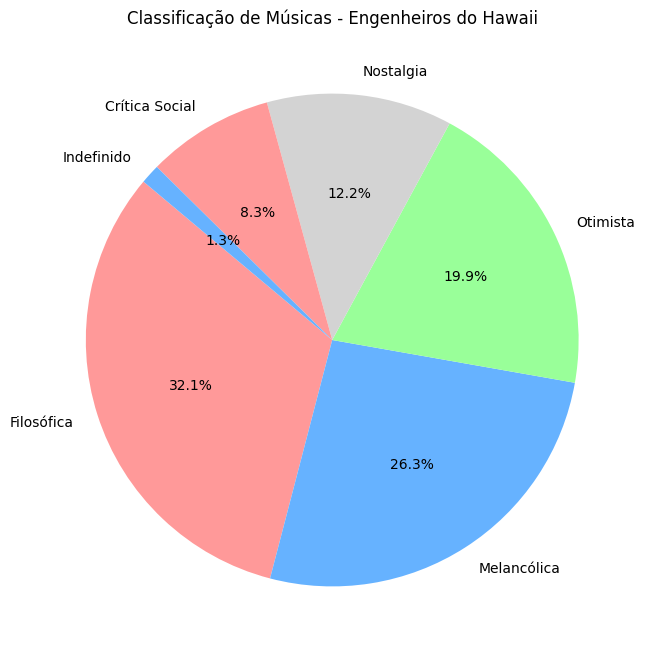

In [15]:
# Nessa célula aplicamos a classificação nas músicas

if 'df' in locals() and 'tokens' in df.columns:
    df['categoria_intuitiva'] = df['tokens'].apply(classificar_sentimento)

    contagem_categorias = df['categoria_intuitiva'].value_counts()

    print("--- DISTRIBUIÇÃO DAS CATEGORIAS ---")
    print(contagem_categorias)

    # Mostrar com gráfico
    plt.figure(figsize=(8, 8))
    plt.pie(
        contagem_categorias,
        labels=contagem_categorias.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=['#FF9999', '#66B2FF', '#99FF99', '#D3D3D3']
    )
    plt.title('Classificação de Músicas - Engenheiros do Hawaii')
    plt.show()

else:
    print("Erro: DataFrame 'df' ou coluna 'tokens' não encontrados")

In [16]:
# Nessa célula avaliamos 5 músicas especificas para confirmar a eficiência do classificador

musicas_teste = ['infinita highway', 'pra ser sincero', 'o papa é pop', 'refrão de bolero', 'era um garoto que como eu']

print("--- VALIDAÇÃO QUALITATIVA ---")

if 'df' in locals():
    for musica in musicas_teste:
        resultado = df[df['titulo'].str.contains(musica, case=False, na=False)]

        if not resultado.empty:
            titulo_real = resultado.iloc[0]['titulo']
            cat = resultado.iloc[0]['categoria_intuitiva']
            print(f"Música: '{titulo_real}' -> Classificada como: {cat.upper()}")
        else:
            print(f"Música '{musica}' não encontrada no dataset.")

--- VALIDAÇÃO QUALITATIVA ---
Música: 'Infinita Highway' -> Classificada como: FILOSÓFICA
Música: 'Pra Ser Sincero' -> Classificada como: FILOSÓFICA
Música: 'O Papa é Pop' -> Classificada como: CRÍTICA SOCIAL
Música: 'Refrão de Bolero' -> Classificada como: OTIMISTA
Música: 'Era um Garoto que como Eu Amava os Beatles e os Rolling Stones' -> Classificada como: NOSTALGIA


**ANÁLISE DA CLASSIFICAÇÃO**

A classificação fez sentido em algumas músicas, mas achamos que errou em outras:

"Infinita Highway" como FILOSÓFICA - Faz todo sentido. A música fala sobre ir sem saber pra onde, sobre viver o caminho e não o destino. É bem existencialista mesmo.

"Pra Ser Sincero" como FILOSÓFICA - Também faz sentido. A letra questiona relacionamentos, sinceridade, expectativas em uma relação.

"O Papa é Pop" como CRÍTICA SOCIAL - Acertou. Essa música é crítica e irônica, fala sobre alienação da mídia e cultura de massa, é provocativa e crítica.

"Refrão de Bolero" como OTIMISTA - Achamos que a IA errou. A música fala de um amor meio que perdido, de um erro cometido "Agora me arrependo / Roendo as unhas". É mais melancólica, não otimista, mas é compreensível que a IA tenha se confundido, uma vez que os sentimentos "concretos" declarados em palavras nessa música não são tão claros.

"Era um Garoto que como Eu Amava os Beatles e os Rolling Stones" como NOSTALGIA - Faz sentido, em partes. A música realmente fala de memórias da juventude, dos Beatles e Rolling Stones, de um tempo que já foi. Entretanto, o centro da música se concentra na crítica ao contexto dabrutalidade da Guerra do Vietnã, refletindo que a juventude, sonhos e a guitarra foi tirada do jovem, dando lugar a morte, a violência, ao instrumento que faz "ra ta ta ta", se referindo a uma arma. Portanto, achamos que a música deveria ser considerada de CRÍTICA SOCIAL.



---



**OBSERVAÇÃO**

**No roteiro original, pretendiamos criar apenas 3 dicionários (filosófico, otimista e melancólico), mas durante o desenvolvimento da atividade, achamos interessante crescer o escopo da classificação de sentimentos, uma vez que as músicas de Engenheiros abordam bastante sobre crítica social e nostalgia**
